## Бутстрап
Бутстрап позволяет многократно извлекать подвыборки из выборки, полученной в рамках экспериментва

В полученных подвыборках считаются статистики (среднее, медиана и т.п.)

Из статистик можно получить ее распределение и взять доверительный интервал

ЦПТ, например, не позволяет строить доверительные интервал для медианы, а бутстрэп это может сделать

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm
import seaborn as sns

plt.style.use('ggplot')

In [2]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа

# На нашем курсе по аналитике https://karpov.courses/ секцию про bootstrap читают ребята из https://www.experiment-fest.ru/
# Функция get_bootstrap взята из их занятия по АБ тестам

In [3]:
def cliffsDelta(lst1, lst2, **dull):
    """Returns delta and true if there are more than 'dull' differences"""
    if not dull:
        dull = {'small': 0.147, 'medium': 0.33, 'large': 0.474} # effect sizes from (Hess and Kromrey, 2004)
    m, n = len(lst1), len(lst2)
    lst2 = sorted(lst2)
    j = more = less = 0
    for repeats, x in runs(sorted(lst1)):
        while j <= (n - 1) and lst2[j] < x:
            j += 1
        more += j*repeats
        while j <= (n - 1) and lst2[j] == x:
            j += 1
        less += (n - j)*repeats
    d = (more - less) / (m*n)
    size = lookup_size(d, dull)
    return d #, size                  # Закоментировал возвращение дискретного значения размера эффекта,
                                      # чтобы без проблем использовать bootstrap 

def lookup_size(delta: float, dull: dict) -> str:
    """
    :type delta: float
    :type dull: dict, a dictionary of small, medium, large thresholds.
    """
    delta = abs(delta)
    if delta < dull['small']:
        return 'negligible'
    if dull['small'] <= delta < dull['medium']:
        return 'small'
    if dull['medium'] <= delta < dull['large']:
        return 'medium'
    if delta >= dull['large']:
        return 'large'

def runs(lst):
    """Iterator, chunks repeated values"""
    for j, two in enumerate(lst):
        if j == 0:
            one, i = two, 0
        if one != two:
            yield j - i, one
            i = j
        one = two
    yield j - i + 1, two

In [4]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95, # уровень значимости
    N = 1,
    concat = True,
    plot_flag = False,
    colname = ''
):
    if (concat):
        boot_len_1 = len(data_column_1)
        boot_len_2 = len(data_column_2)
        data_for_sample_1 = pd.Series(np.concatenate((data_column_1, data_column_2), axis=None))
        data_for_sample_2 = pd.Series(np.concatenate((data_column_1, data_column_2), axis=None))
        const = statistic(data_column_1) - statistic(data_column_2)
    else:
        boot_len_1 = max([len(data_column_1), len(data_column_2)])
        boot_len_2 = max([len(data_column_1), len(data_column_2)])
        data_for_sample_1 = data_column_1
        data_for_sample_2 = data_column_2
        const = 0
        
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_for_sample_1.sample(
            boot_len_1, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_for_sample_2.sample(
            boot_len_2,
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1) - statistic(samples_2)) 
    
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
    quants.columns = [str(statistic.__name__)]
    
    if (concat):
        p_value = norm.cdf(x = -np.abs(const), loc = np.mean(boot_data), scale = np.std(boot_data)) * 2
    else:
        p_1 = norm.cdf(x = 0, loc = np.mean(boot_data), scale = np.std(boot_data))
        p_2 = norm.cdf(x = 0, loc = -np.mean(boot_data), scale = np.std(boot_data))
        p_value = min(p_1, p_2) * 2
    
    if p_value > 1:
        p_value = 1
        
    # Визуализация
    
    if(plot_flag):
        sns.displot(x = pd_boot_data[0], kind = "kde", fill = True)
        plt.axvline(const, linestyle='-', color='black')
        plt.axvline(quants.values[0], linestyle='--', color='green')
        plt.axvline(quants.values[1], linestyle='--', color='green')
        plt.xlabel('Разность ' + str(statistic.__name__) + ' двух групп')

        plt.title("Histogram of " + colname)
        plt.savefig(f'plots/fighter_champion_bootstrap/Histogram of {colname}', bbox_inches='tight')
        plt.show()
        

    if (const >= quants.iloc[:, 0].iloc[0]) & (const <= quants.iloc[:, 0].iloc[1]):
        result = False
    else:
        if (p_value >= 0.01 / N):
            result = False
        else:
            result = True
            
    observed_difference = statistic(data_column_1) - statistic(data_column_2)
       
    return {"result": result,
            "observed_difference": observed_difference,
            "quants": quants,
            "p_value": p_value}

In [5]:
data = pd.read_csv('data/fighters_df_champ.csv', sep=',', index_col=0)
# data = data.drop(['brow_a', 'brow_b', 'brow_c', 'brow_d'], axis=1)
data['champ'] = data['champ'].fillna(0).astype('str')
data['champ'] = data['champ'].replace({'1.0':'champion', '0.0':'fighter'})
data = data[~data['Асимметрия челюсти'].isna()]
data

,Асимметрия челюсти,Высота бровей,Наклон глаз,Полнота верхней губы,Полнота нижней губы,Асимметрия размера глаз,Ширина посадки глаз,Скулы,Форма головы,Верхнее веко,...,significantStrikesLandPerMinute,significantStrikesMissedPerMinute,submissionAttemptsPer15minutes,takedownsAccuracy,takedownsDefendPercent,takedownsPer15min,wins,looses,name,champ
1,3.390337,0.155163,-7.744183,0.728999,5.310254,0.981586,0.720082,-1.353690,1.308804,0.349305,...,NaN,NaN,NaN,NaN,NaN,NaN,6,0,Giacomo Lemos,fighter
2,0.009935,0.225912,-9.292315,1.778055,5.545871,1.013628,0.817481,-6.867299,1.483796,0.820615,...,2.45,2.45,0.2,24.0,47.0,1.23,20,5,Shamil Abdurakhimov,fighter
3,0.891460,0.141038,-12.152457,1.414088,6.599077,0.937218,0.739006,-0.005200,1.537365,0.550704,...,2.05,2.90,NaN,20.0,80.0,0.64,15,5,Klidson Abreu,fighter
4,-2.407352,0.226568,2.480188,1.533930,7.669650,1.002826,0.859598,-2.441267,1.252503,0.766965,...,3.10,3.62,1.0,67.0,92.0,2.29,14,6,Yoshihiro Akiyama,fighter
5,0.361198,0.249773,-3.179830,1.625533,5.747126,1.164870,0.928726,-1.762808,1.334151,0.855537,...,4.93,7.19,0.2,25.0,50.0,0.94,20,8,Jessica Aguilar,fighter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3656,1.327879,0.198817,-2.385944,1.415175,7.075874,0.790980,0.791811,10.183630,1.344508,0.430224,...,NaN,NaN,NaN,NaN,NaN,NaN,6,0,Isi Fitikefu,fighter
3659,-5.211018,0.236392,2.726311,1.393396,7.376801,1.167989,0.803615,1.016116,1.525618,1.016959,...,NaN,NaN,NaN,NaN,NaN,NaN,7,1,Josiane Nunes,fighter
3660,0.474190,0.190069,-6.709837,1.248210,6.241051,0.900908,0.867235,16.762554,1.501060,0.398726,...,NaN,NaN,NaN,NaN,NaN,NaN,15,6,Aori Qileng,fighter
3662,2.307039,0.188664,-8.572998,1.092283,5.041305,0.996280,0.849671,14.322720,1.336051,0.439944,...,NaN,NaN,NaN,NaN,NaN,NaN,9,4,Na Liang,fighter


In [6]:
cols = ['Асимметрия челюсти', 'Высота бровей', 'Наклон глаз',
       'Полнота верхней губы', 'Полнота нижней губы',
       'Асимметрия размера глаз', 'Ширина посадки глаз', 'Скулы',
       'Форма головы', 'Верхнее веко', 'Асимметрия брови', 'Наклон бровей',
       'Размер рта', 'Асимметрия наклона глаз', 'Асимметрия носа',
       'Размер глаз', 'Оттопыренность ушей', 'Ширина челюсти', 'Уголки рта',
       ]

In [7]:
data_norm = data.copy()
for col in tqdm(cols):
    data_norm[col] = (data_norm[col] - data_norm[col].quantile(0.01)) / (data_norm[col].quantile(0.99) - data_norm[col].quantile(0.001))
    

  0%|          | 0/19 [00:00<?, ?it/s]

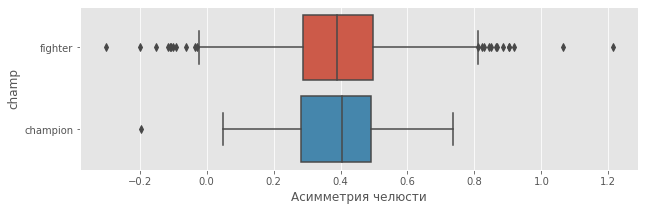

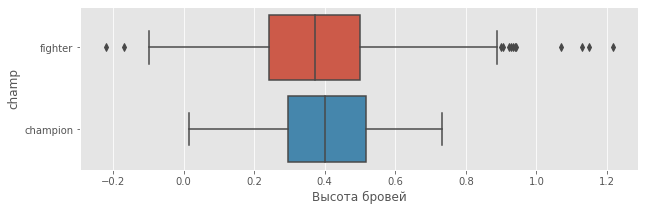

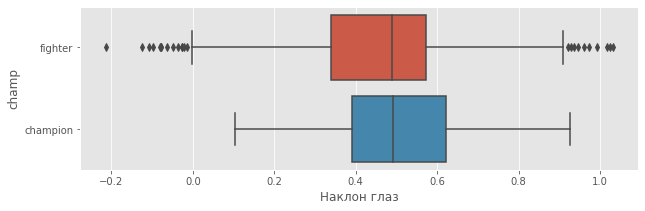

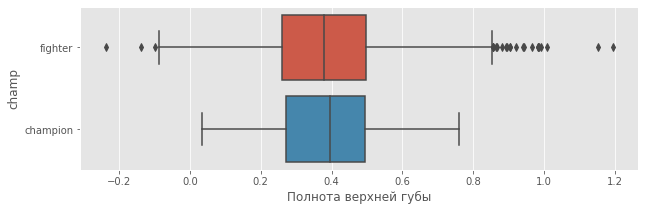

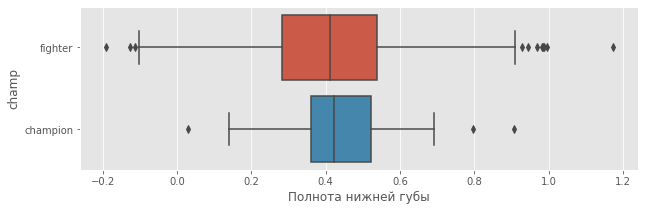

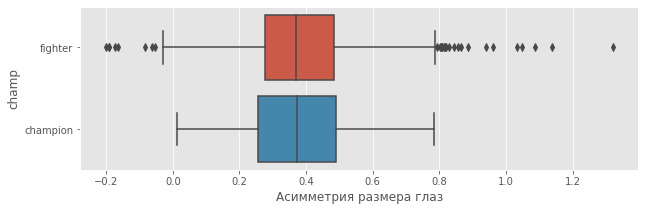

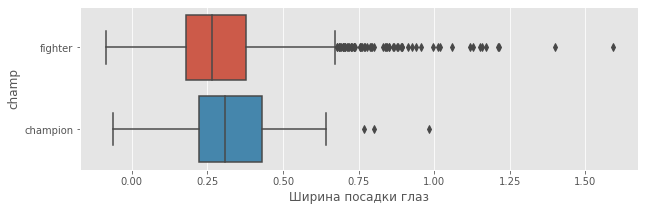

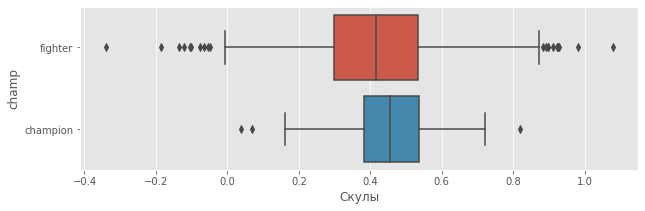

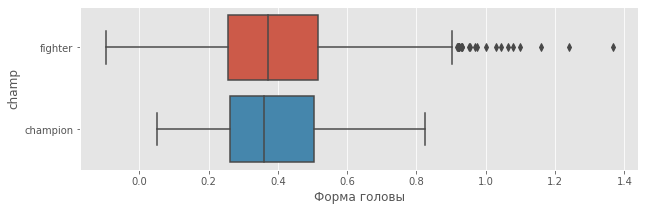

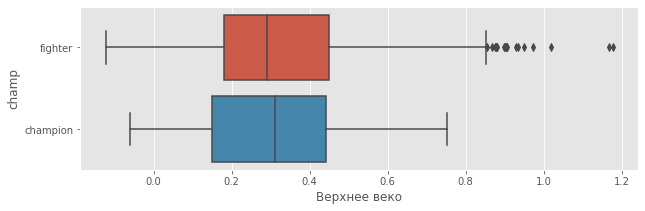

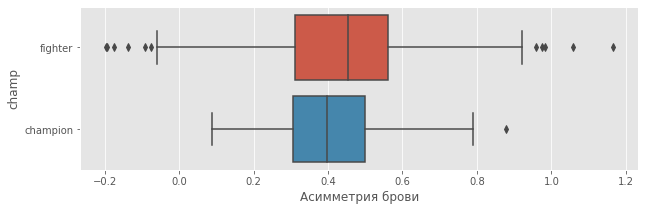

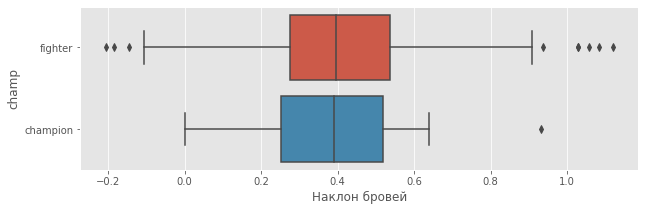

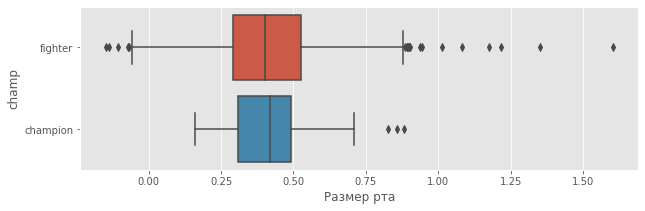

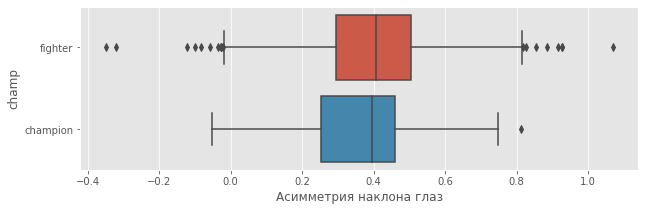

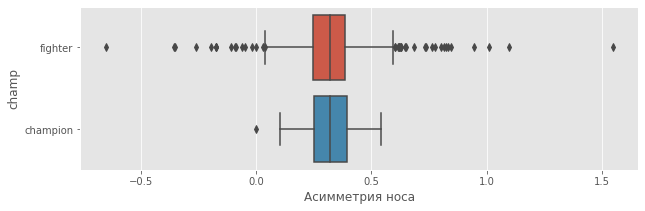

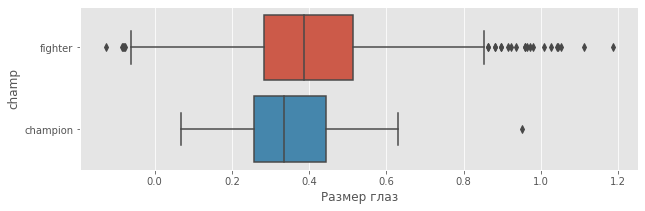

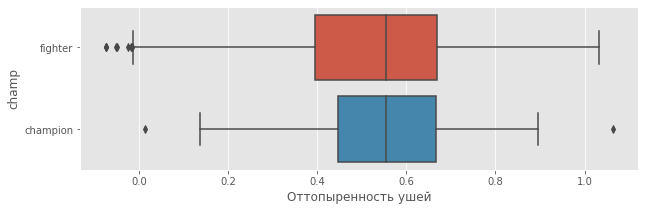

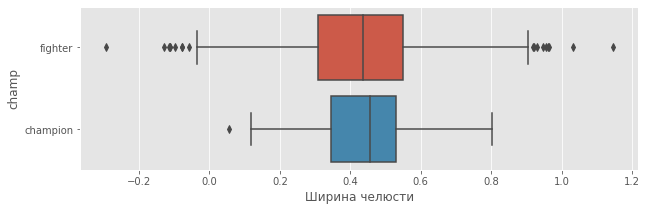

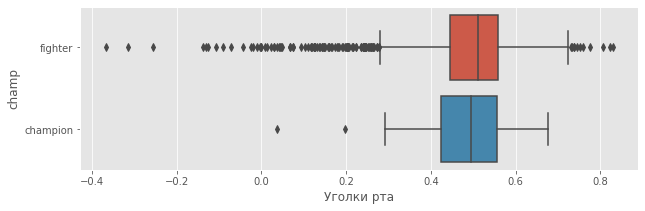

In [18]:
for i in cols:
    f, ax = plt.subplots(figsize=(10, 3))
    sns.boxplot(data=data_norm, x=i, y="champ")
    plt.savefig(f'plots/fighter_champion_boxplot/{i}', bbox_inches='tight')
    plt.show()

In [9]:
war = data_norm[data_norm['champ'] == 'champion']
hum = data_norm[data_norm['champ'] == 'fighter']

  0%|          | 0/5000 [00:00<?, ?it/s]

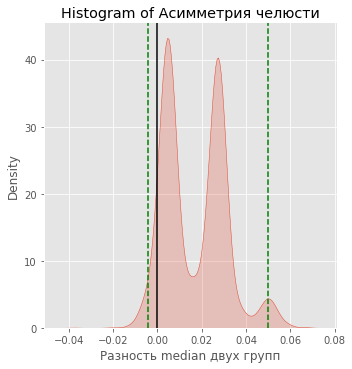

p_value:  0.23588162522861966 Statistical value:  False


  0%|          | 0/5000 [00:00<?, ?it/s]

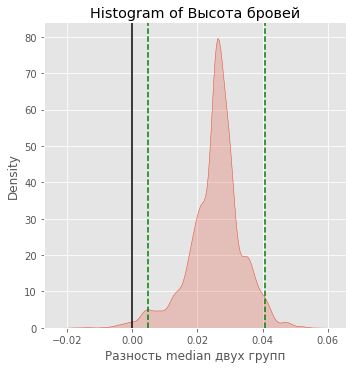

p_value:  0.001825153595702426 Statistical value:  False


  0%|          | 0/5000 [00:00<?, ?it/s]

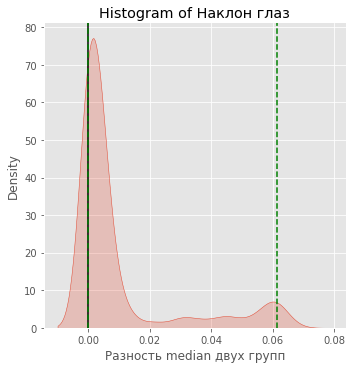

p_value:  0.5758252599453557 Statistical value:  False


  0%|          | 0/5000 [00:00<?, ?it/s]

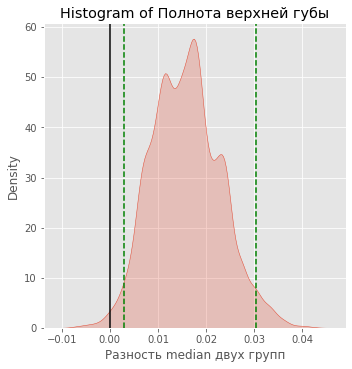

p_value:  0.02637519957190409 Statistical value:  False


  0%|          | 0/5000 [00:00<?, ?it/s]

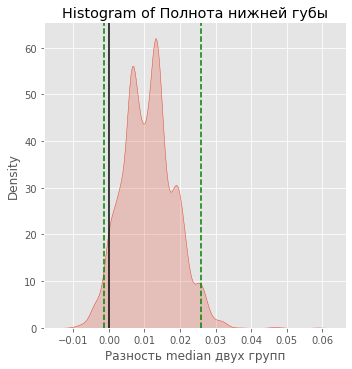

p_value:  0.12314377470679395 Statistical value:  False


  0%|          | 0/5000 [00:00<?, ?it/s]

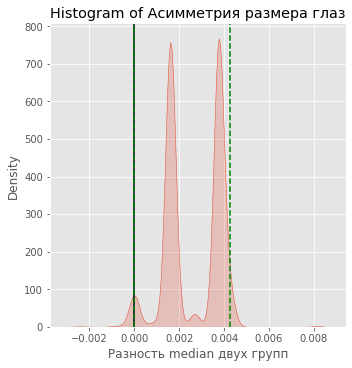

p_value:  0.037136675588401495 Statistical value:  False


  0%|          | 0/5000 [00:00<?, ?it/s]

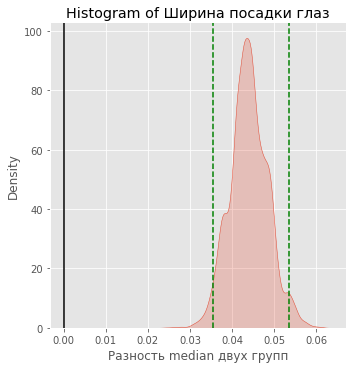

p_value:  4.421253494229704e-22 Statistical value:  True


  0%|          | 0/5000 [00:00<?, ?it/s]

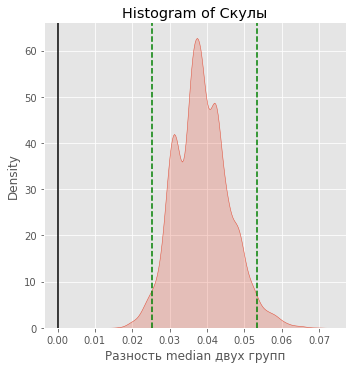

p_value:  8.819014082294639e-08 Statistical value:  True


  0%|          | 0/5000 [00:00<?, ?it/s]

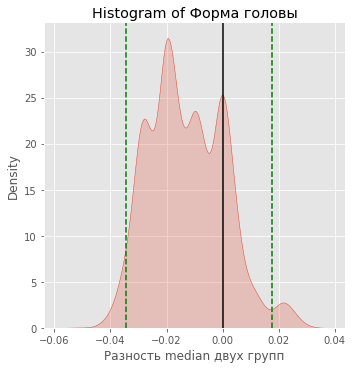

p_value:  0.34153461679807917 Statistical value:  False


  0%|          | 0/5000 [00:00<?, ?it/s]

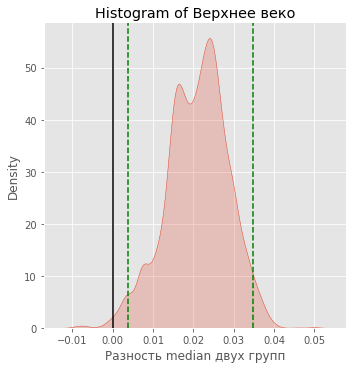

p_value:  0.0060192753642517175 Statistical value:  False


  0%|          | 0/5000 [00:00<?, ?it/s]

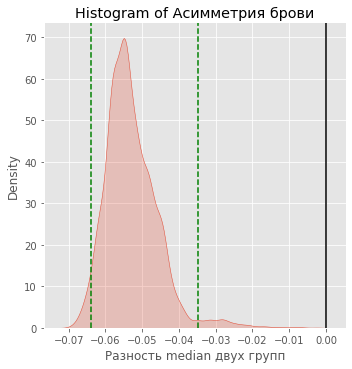

p_value:  4.134096705784224e-13 Statistical value:  True


  0%|          | 0/5000 [00:00<?, ?it/s]

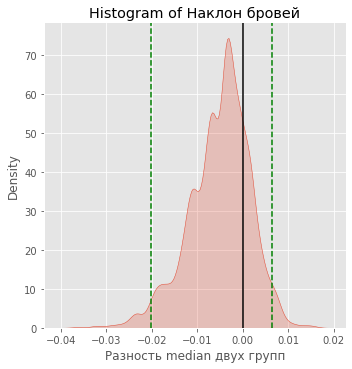

p_value:  0.4417055573165799 Statistical value:  False


  0%|          | 0/5000 [00:00<?, ?it/s]

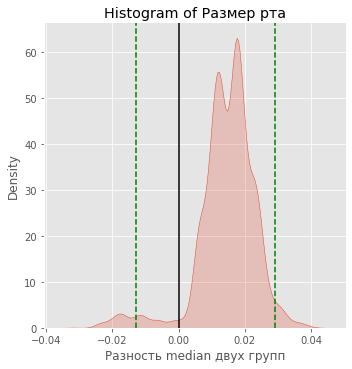

p_value:  0.10521183617625814 Statistical value:  False


  0%|          | 0/5000 [00:00<?, ?it/s]

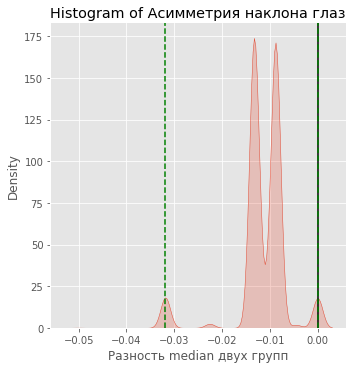

p_value:  0.03814087133337216 Statistical value:  False


  0%|          | 0/5000 [00:00<?, ?it/s]

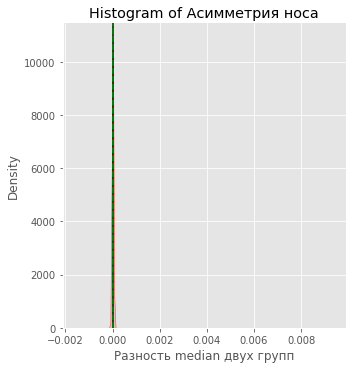

p_value:  0.9726880182897748 Statistical value:  False


  0%|          | 0/5000 [00:00<?, ?it/s]

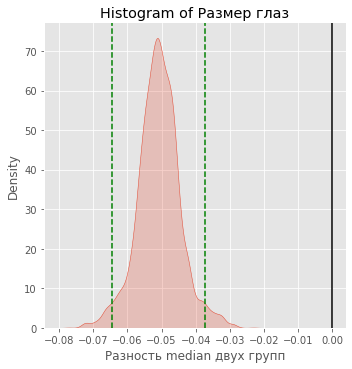

p_value:  8.805221746669526e-16 Statistical value:  True


  0%|          | 0/5000 [00:00<?, ?it/s]

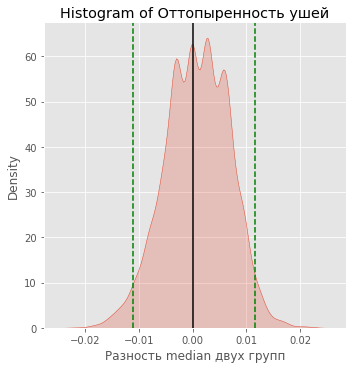

p_value:  0.8917861256013111 Statistical value:  False


  0%|          | 0/5000 [00:00<?, ?it/s]

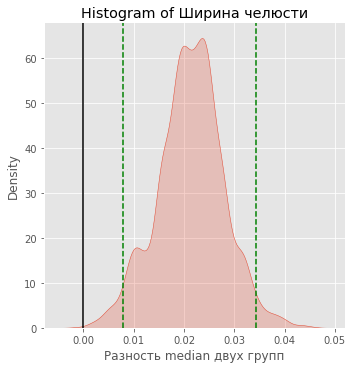

p_value:  0.0013299562643765293 Statistical value:  False


  0%|          | 0/5000 [00:00<?, ?it/s]

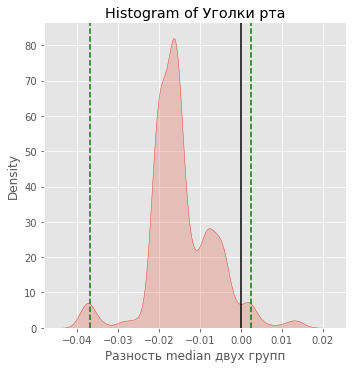

p_value:  0.07141210903060306 Statistical value:  False


In [13]:
l_bot_quant = []
l_top_quant = []
l_observed_difference = []
l_p_value = []
l_result = []

s = np.median
n = 19 # Поправка на множественное сравнение (количество проверяемых гипотез)
for i in cols:
    res = get_bootstrap(
        war[i], # числовые значения первой выборки
        hum[i], # числовые значения второй выборки
        boot_it = 5000, # количество бутстрэп-подвыборок
        statistic = s, # интересующая нас статистика
        bootstrap_conf_level = 0.95,
        N = n,
        concat = False,
        plot_flag = True,
        colname = i)
    
    l_observed_difference.append(res['observed_difference'])
    l_p_value.append(res['p_value'])
    l_result.append(res['result'])
    l_bot_quant.append(res['quants'].iloc[:, 0].iloc[0])
    l_top_quant.append(res['quants'].iloc[:, 0].iloc[1])
    
    print("p_value: ", res['p_value'], \
          "Statistical value: ", res['p_value'] < (0.01 /38))

In [15]:
res_boostrap = pd.DataFrame([cols, l_observed_difference, l_bot_quant, l_top_quant, l_p_value, l_result])
res_boostrap = res_boostrap.T
res_boostrap.columns = ['Feature', 'Медиана наблюдаемой разницы, %', 
                        'Нижняя граница доверительного интервала', 
                        'Верхняя граница доверительного интервала', 'p_value', 'Значимость']
res_boostrap['p_value'] = res_boostrap['p_value'].astype('float')
res_boostrap['Медиана наблюдаемой разницы, %'] = res_boostrap['Медиана наблюдаемой разницы, %']*100

res_boostrap.sort_values(by=['p_value'], ascending=False).reset_index(drop=True)

,Feature,"Медиана наблюдаемой разницы, %",Нижняя граница доверительного интервала,Верхняя граница доверительного интервала,p_value,Значимость
0,Асимметрия носа,0.0,0.0,0.0,9.726880e-01,False
1,Оттопыренность ушей,0.108559,-0.011148,0.011671,8.917861e-01,False
2,Наклон глаз,0.301059,0.0,0.061478,5.758253e-01,False
3,Наклон бровей,-0.480306,-0.020071,0.006508,4.417056e-01,False
4,Форма головы,-1.255183,-0.034568,0.01757,3.415346e-01,False
5,Асимметрия челюсти,1.612481,-0.004387,0.050086,2.358816e-01,False
6,Полнота нижней губы,0.968196,-0.001327,0.026011,1.231438e-01,False
7,Размер рта,1.6411,-0.012967,0.029085,1.052118e-01,False
8,Уголки рта,-1.737912,-0.036956,0.002412,7.141211e-02,False
9,Асимметрия наклона глаз,-1.10513,-0.031875,0.0,3.814087e-02,False
